In [46]:
#library import
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
from IPython.display import display
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
plt.rcParams['font.family'] = 'Malgun Gothic'
%matplotlib inline
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')


from sklearn.metrics import make_scorer

# 시계열

from datetime import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
import statsmodels.api as sm


from sklearn.metrics import mean_absolute_error, mean_squared_error

data_dir='C:/Users/kdh2/BIGCON/data/total'
data_list = os.listdir(data_dir)


#항목별 저장
data_list_single_hitter = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('개인타자')]
data_single_hitter = [pd.read_csv(os.path.join(data_dir, data_list_single_hitter[x]), encoding='cp949') for x in range(len(data_list_single_hitter))]
data_list_single_pitcher = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('개인투수')]
data_single_pitcher = [pd.read_csv(os.path.join(data_dir, data_list_single_pitcher[x]), encoding='cp949') for x in range(len(data_list_single_pitcher))]
data_list_games = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('경기')]
data_games = [pd.read_csv(os.path.join(data_dir, data_list_games[x]), encoding='cp949') for x in range(len(data_list_games))]
data_list_player_enroll = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('등록선수')]
data_player_enroll = [pd.read_csv(os.path.join(data_dir, data_list_player_enroll[x]), encoding='cp949') for x in range(len(data_list_player_enroll))]
data_list_players = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('선수')]
data_players = [pd.read_csv(os.path.join(data_dir, data_list_players[x]), encoding='cp949') for x in range(len(data_list_players))]
data_list_teams = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('팀')]
data_teams = [pd.read_csv(os.path.join(data_dir, data_list_teams[x]), encoding='cp949') for x in range(len(data_list_teams))]
data_list_team_hitter = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('팀타자')]
data_team_hitter = [pd.read_csv(os.path.join(data_dir, data_list_team_hitter[x]), encoding='cp949') for x in range(len(data_list_team_hitter))]
data_list_team_pitcher = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('팀투수')]
data_team_pitcher = [pd.read_csv(os.path.join(data_dir, data_list_team_pitcher[x]), encoding='cp949') for x in range(len(data_list_team_pitcher))]


team=pd.concat(data_team_hitter,axis=0)
for i in range(0,5):
     data_team_hitter[i]['AVG']=data_team_hitter[i]['HIT']/data_team_hitter[i]['AB']

team.columns

from datetime import datetime as dt
from dateutil.parser import parse
team_2016=data_team_hitter[0]
team_2017=data_team_hitter[1]
team_2018=data_team_hitter[2]
team_2019=data_team_hitter[3]
team_2020=data_team_hitter[4]
df_list=[team,team_2016,team_2017,team_2018,team_2019,team_2020]



In [47]:
from IPython.display import display
import itertools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

import warnings
warnings.filterwarnings(action='ignore')

In [48]:

from sklearn.preprocessing import LabelEncoder
from datetime import datetime

def team_hitter_eda(year, team_name):
    year_index = year - 2016 
    
    # team_hitter data에 해당 경기의 해당 팀의 홈 어웨이 여부 column 추가
    data_games_year = data_games[year_index]
    data_games_year = data_games_year[['G_ID', 'VISIT_KEY', 'HOME_KEY']]
    data_games_year = data_games_year.set_index('G_ID')
    
    data_team_hitter_year = data_team_hitter[year_index]
    data_team_hitter_year = pd.merge(data_team_hitter_year, data_games_year, how='left', on=['G_ID'])

    data_team_hitter_year_team = data_team_hitter_year[data_team_hitter_year.T_ID == team_name]
    df = data_team_hitter_year_team
    df['HOME_KEY'] = df['HOME_KEY'].map(lambda x: 1 if x == team_name else 0 )
    df = df.drop(columns = ['VISIT_KEY', 'G_ID'])
    
    df.reset_index(inplace=True, drop=True) #index 재정렬
    
    # LabelEncoding
    encoder = LabelEncoder()

    df['VS_T_ID'] = encoder.fit_transform(df['VS_T_ID']) #상대편
    df['TB_SC'] = encoder.fit_transform(df['TB_SC']) #이닝 초/말
    
    
    ### 이부분은 모든 EDA에서 동일하게 작성
    
    # GDAY_DS => Datetime type
    df['GDAY_DS'] = df['GDAY_DS'].astype('string') + (df['HEADER_NO']+1).astype('string')
    df['H1']=df['HIT']-df['H2']-df['H3']-df['HR']
    dt = []
    for i in df['GDAY_DS']:
        dt_ = datetime.strptime(i, '%Y%m%d%H')
        dt.append(dt_)
    df['GDAY_DS'] = pd.Series(dt)
    df['month']=df['GDAY_DS'].apply(lambda x: x.month)
    
    #장타율
    df['SLG']=(df['HIT']+df['HP']+df['BB'])/(df['AB']+df['BB']+df['HP']+df['SF'])
    #출루율
    df['OBA']=(df['H1']+2*df['H2']+3*df['H3']+4*df['HR'])/df['AB']
    df['W_OPS']=0.57* df['SLG']+0.43*df['OBA']
    
    
    
    df = df.drop(columns=['T_ID'])
    #lags
    lags=[1,4,6,12,30,60]
    for lag in lags:
        df['AVG_lag_'+str(lag)]=df['AVG'].shift(lag).astype(np.float16)
    #SK Expanding window 추가
    df['expanding_AVG_mean']=df['AVG'].transform(lambda x: x.expanding(2).mean().astype(np.float16))
    #rolling window
    df['rolling_AVG_mean']=df['AVG'].transform(lambda x: x.rolling(window=7).mean().astype(np.float16))
    #trend
    df['avg_AVG'] = df['AVG'].mean()
    df['AVG_trend'] = (df['AVG'] - df['avg_AVG']).astype(np.float16)
    df.drop(['avg_AVG'],axis=1,inplace=True)
    # 경기당 타율 column 생성
    df['AVG'] = df['HIT'] / df['AB']
    
    # Drop Categorical feature for 시계열 => coint 과정에서 singular matrix 발생
    df = df.drop(columns=[ 'HOME_KEY'])
    

#     df = df.drop(columns=['T_ID', 'HEADER_NO', 'CG_CK', 'BK'])
#     df = df.drop(columns=['TB_SC', 'HR', 'SB', 'VS_T_ID', 'HOME_KEY', 'HOLD', 'INN2', 'BF', 'CS', 'SH', 'HP', 'GD', 'ERR' ,'ER'])
    df_year_team_name = df
    
    return df_year_team_name

In [49]:
def add_y_next(df):
    df['ym']=df['GDAY_DS'].apply(lambda x: str(x.year)+str(x.month))



    a=df['GDAY_DS'].apply(lambda x: str(x.year)+str(x.month)).unique()
    b=list(range(len(a)))
    list_C = [ x for x in zip(a,b) ]
    dict1=dict(list_C)
    


    df['dummy']=df['ym'].map(dict1)

    df['dummy+1']=df['dummy']+1

    y_dict=df.groupby(['dummy'])['AVG'].mean().to_dict()
    

    df['y_next']=df['dummy+1'].map(y_dict)

    df.drop(['dummy','dummy+1','ym','GDAY_DS'],axis=1,inplace=True)
    #걍 날짜는 삭제(시계열 피쳐로 잡아주니까)
    df.dropna(inplace=True)#일단 드랍하고 진행
    return df

In [34]:

#데이터 전체 취합하기
names=team['T_ID'].unique()
df_list=[0]*5
df_list2=[0]*10
for i in range(len(df_list2)):
    for name in names:
        df_list[0]=team_hitter_eda(2016, name)
        df_list[1]=team_hitter_eda(2017, name)
        df_list[2]=team_hitter_eda(2018, name)
        df_list[3]=team_hitter_eda(2019, name)
        df_list[4]=team_hitter_eda(2020, name)
        df_list2[i]=add_y_next(pd.concat([df_list[0],df_list[1],df_list[2],df_list[3],df_list[4]],axis=0))



data=pd.concat([df_list2[0],df_list2[1],df_list2[2],df_list2[3],df_list2[4]
               ,df_list2[5],df_list2[6],df_list2[7],df_list2[8],df_list2[9]],axis=0)


In [41]:
names

array(['LG', 'HH', 'NC', 'HT', 'SK', 'KT', 'WO', 'LT', 'SS', 'OB'],
      dtype=object)

In [44]:
LG=df_list2[0]
LG

,VS_T_ID,HEADER_NO,TB_SC,PA,AB,RBI,RUN,HIT,H2,H3,...,AVG_lag_1,AVG_lag_4,AVG_lag_6,AVG_lag_12,AVG_lag_30,AVG_lag_60,expanding_AVG_mean,rolling_AVG_mean,AVG_trend,y_next
60,1,0,1,42,36,8,8,11,1,0,...,0.295410,0.297363,0.309570,0.222168,0.351318,0.258057,0.293945,0.271484,0.012718,0.282466
61,1,0,1,42,39,7,7,13,2,0,...,0.305664,0.199951,0.242432,0.225830,0.342773,0.315674,0.294678,0.274902,0.040497,0.282466
62,1,0,1,50,40,13,13,15,3,1,...,0.333252,0.250000,0.297363,0.166626,0.285645,0.214233,0.295898,0.293701,0.082153,0.282466
63,7,0,1,38,34,2,2,7,1,0,...,0.375000,0.295410,0.199951,0.300049,0.384521,0.166626,0.294434,0.280762,-0.086975,0.282466
64,7,0,1,43,36,6,6,11,2,0,...,0.205933,0.305664,0.250000,0.290283,0.428467,0.277832,0.294678,0.295898,0.012718,0.282466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,4,0,1,42,38,7,7,13,2,0,...,0.300049,0.264648,0.297363,0.068970,0.225830,0.399902,0.271484,0.306641,0.069824,0.375000
140,7,0,1,46,41,11,11,14,3,0,...,0.342041,0.353027,0.333252,0.333252,0.218750,0.275879,0.271973,0.312988,0.069214,0.375000
141,0,0,0,48,39,7,7,13,1,0,...,0.341553,0.256348,0.264648,0.281250,0.399902,0.235352,0.272461,0.312988,0.061066,0.375000
142,3,0,1,34,28,2,3,4,0,0,...,0.333252,0.300049,0.353027,0.315674,0.351318,0.242432,0.271484,0.295654,-0.129395,0.375000


In [55]:

from scipy.stats import shapiro

shapiro(data['y_next'])
#LG만 해도p값이 0.05보다 작다. 즉, 유의수준 0.05하에서 타깃 값이 정규성을 만족한다는 귀무가설을 기각하게 된다.


(0.8801729083061218, 2.802596928649634e-45)

optimal lambda: 1.3591866384688165


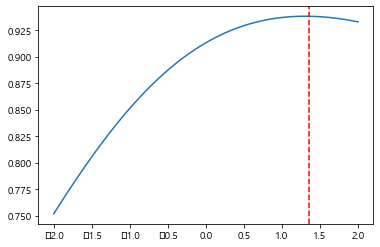

In [57]:
import scipy as sp
x, y = sp.stats.boxcox_normplot(LG['y_next'], -2, 2)
plt.plot(x, y);
y2, l = sp.stats.boxcox(LG['y_next'])
plt.axvline(x=l, color='r', ls="--");
print("optimal lambda:", l)

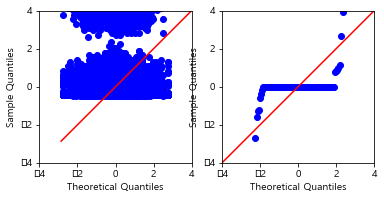

In [58]:

import statsmodels.graphics.gofplots as sm
ax1 = plt.subplot(121);
sm.qqplot(LG, fit=True, line='45', ax=ax1);
ax1.axis("square"); ax1.set_xlim(-4, 4); ax1.set_ylim(-4, 4); 
ax2 = plt.subplot(122);
sm.qqplot(np.diff(y2), fit=True, line='45', ax=ax2);
ax2.axis("square"); ax2.set_xlim(-4, 4); ax2.set_ylim(-4, 4); 

- optimal lambda 를 사용하여 box-cox변환을 취해도 정규성을 만족시킬 방법이 없음
- 노이즈를 추가하면 정규성을 만족시킬 수 있으나 적절하지 못한 방법임.
- 따라서 논문에서 읽었던 best subset selection이나 ridge, lasso등의 회귀 기반의 모델은 사용이 어려워짐
- 이에 따라 분포에 대한 가정이 필요 없는 non-parametric한 방법의 사용이 필요하게 됨

# 후보 models
- LGBM 등의 tree 계열 모델들
- LSTM
- KNN
- SVR
- 